In [1]:
import numpy as np
import struct
from array import array
import pandas as pd
import os
from os.path  import join
import random as rn
from sklearn.neural_network import MLPClassifier
import graphviz
import pydotplus
from IPython.display import Image
from io import StringIO
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import log_loss
import random
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import time
import itertools
import matplotlib as mpl

from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.random_projection import SparseRandomProjection

In [2]:
"""
Loading in the dataset into a pandas dataframe object.

For the following segments the code snippets were retreved from: https://www.kaggle.com/code/anetakovacheva/interpreting-a-music-genre-classifier
"""

%matplotlib inline

input_path = 'data/musicgenre_datafolder'
file_path = join(input_path, 'music_genre.csv')

music_data = pd.read_csv(file_path)

"""
Cleaning and Pre-Processing all of the data
"""

"""
There are some duplicated data that needs to be cleaned up
"""
music_data.duplicated().any()
duplicated = music_data.duplicated()
music_data[duplicated]
music_data.iloc[9999:10006]
music_data.drop([10000, 10001, 10002, 10003, 10004], inplace = True)

"""
Removing some columns that don't matter or will complicated the training too much
"""
music_data.reset_index(inplace = True)
music_data = music_data.drop(["artist_name", "index", "instance_id", "track_name", "obtained_date"], axis = 1)

"""
Normalizing the music data such that it removes invalid values for 'tempo' and converts
the column values into a float
"""
music_data = music_data.drop(music_data[music_data["tempo"] == "?"].index)
music_data["tempo"] = music_data["tempo"].astype("float")
music_data["tempo"] = np.around(music_data["tempo"], decimals = 2)

"""
Encoding the columns that are strings with LabelEncoder since this will mess
up the algorithms that require numeric values
"""
key_encoder = LabelEncoder()
mode_encoder = LabelEncoder()
music_data["key"] = key_encoder.fit_transform(music_data["key"])
music_data["mode"] = mode_encoder.fit_transform(music_data["mode"])

"""
Separating out the column features from the music genre label
"""
music_features = music_data.drop("music_genre", axis = 1)
music_labels = music_data["music_genre"]

print(music_data)
print(np.unique(music_labels))
print(len(np.unique(music_labels)))

"""
Scaling the features out into a scale centered around 0 with a standard deviation of 1
"""
scaler = StandardScaler()
music_features_scaled = scaler.fit_transform(music_features)
# print(music_features_scaled[0])

"""
Splitting the data into Training and Testing Data Sets
"""
train_features, test_features, train_labels, test_labels = train_test_split(
    music_features_scaled, music_labels, test_size = 0.1, stratify = music_labels)


       popularity  acousticness  danceability  duration_ms  energy  \
0            27.0       0.00468         0.652         -1.0   0.941   
1            31.0       0.01270         0.622     218293.0   0.890   
2            28.0       0.00306         0.620     215613.0   0.755   
3            34.0       0.02540         0.774     166875.0   0.700   
4            32.0       0.00465         0.638     222369.0   0.587   
...           ...           ...           ...          ...     ...   
49995        59.0       0.03340         0.913         -1.0   0.574   
49996        72.0       0.15700         0.709     251860.0   0.362   
49997        51.0       0.00597         0.693     189483.0   0.763   
49998        65.0       0.08310         0.782     262773.0   0.472   
49999        67.0       0.10200         0.862     267267.0   0.642   

       instrumentalness  key  liveness  loudness  mode  speechiness   tempo  \
0               0.79200    1     0.115    -5.201     1       0.0748  100.89   
1

In [3]:
"""
Setting up seed values for reproducability
"""
seed = 1234
np.random.seed(seed)
rn.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

In [4]:
"""
Getting the size values for the training and testing dataset
"""
size_train_samples = np.shape(train_features)[0]
size_test_samples = np.shape(test_features)[0]

In [6]:
"""
Running Sparse Randomized Projections on the Music Genre Dataset to achieve Dimension Reductionality.
This method is to find the best number of components based on the Reconstruction Error score.
"""

n_components_range = list(range(2, 14, 1))

# Hyperparameters for RP
density = 'auto'
eps = 0.1
compute_inverse_components = True
dense_output = False

# Scores for the reconstruction error
reconstruction_error_scores = []

for n_components in n_components_range:
    print(f"Trying {n_components}...")
    rp = SparseRandomProjection(
        n_components = n_components,
        density = density,
        eps = eps,
        compute_inverse_components = compute_inverse_components,
        dense_output = dense_output,
        random_state = seed
    )
    
    x_transformed = rp.fit_transform(train_features)
    x_projected = rp.inverse_transform(x_transformed)
    
    reconstruction_error_scores.append(np.sum((train_features - x_projected) ** 2, axis=1).mean())


Trying 2...
Trying 3...
Trying 4...
Trying 5...
Trying 6...
Trying 7...
Trying 8...
Trying 9...
Trying 10...
Trying 11...
Trying 12...
Trying 13...


Text(0.5, 1.0, 'Reconstruction Error vs Number of Components on RP')

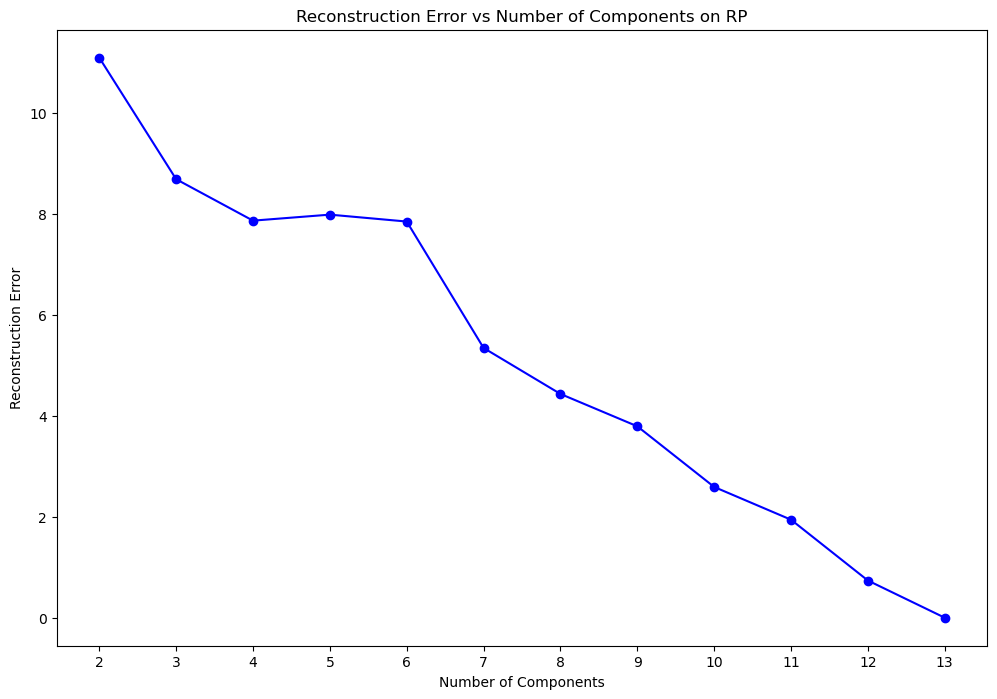

In [7]:
"""
First showing the Reconstruction Error plot to find where the loss is a minimum.
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(n_components_range, reconstruction_error_scores, '-o', color='blue')
ax.set(xlabel='Number of Components', ylabel='Reconstruction Error')
ax.set_xticks(n_components_range)
ax.set_title('Reconstruction Error vs Number of Components on RP')

In [8]:
"""
The analysis above showed us that the Reconstruction Error value is at a good point around 7. Let's use that 
for our dimensional reduction
"""
rpfinal = SparseRandomProjection(
    n_components = 7,
    density = density,
    eps = eps,
    compute_inverse_components = compute_inverse_components,
    dense_output = dense_output,
    random_state = seed
)

rpfinal.fit(train_features)

x_train_transformed = rpfinal.transform(train_features)

In [9]:
"""
Apply Gaussian Mixture Modeling Clustering on this new dataset
"""

# Range of Gaussians we should try
gaussian_range_size = range(2, 13)

# Hyperparameters for GaussianMixtureModel
covariance_type = "full"
tol = 1e-3
reg_covar = 1e-6
max_iter = 100
n_init = 1
init_params = "kmeans"

# Lists to keep track the BIC and AIC scores across number of Gaussians
bic_scores = []
aic_scores = []
siloutte_scores = []

for gaussian_size in gaussian_range_size:
    print(f"Trying size {gaussian_size}...")
    gm = GaussianMixture(
        n_components = gaussian_size,
        covariance_type = covariance_type,
        tol = tol,
        reg_covar = reg_covar,
        max_iter = max_iter,
        init_params = init_params,
        n_init = n_init,
        random_state = seed
    )
    
    gm.fit(x_train_transformed)
    labels = gm.predict(x_train_transformed)
    
    bic_scores.append(gm.bic(x_train_transformed))
    aic_scores.append(gm.aic(x_train_transformed))
    siloutte_scores.append(silhouette_score(x_train_transformed, labels, metric='euclidean'))
    


Trying size 2...
Trying size 3...
Trying size 4...
Trying size 5...
Trying size 6...
Trying size 7...
Trying size 8...
Trying size 9...
Trying size 10...
Trying size 11...
Trying size 12...


Text(0.5, 1.0, 'BIC and AIC Scores Per Number Of Gaussians')

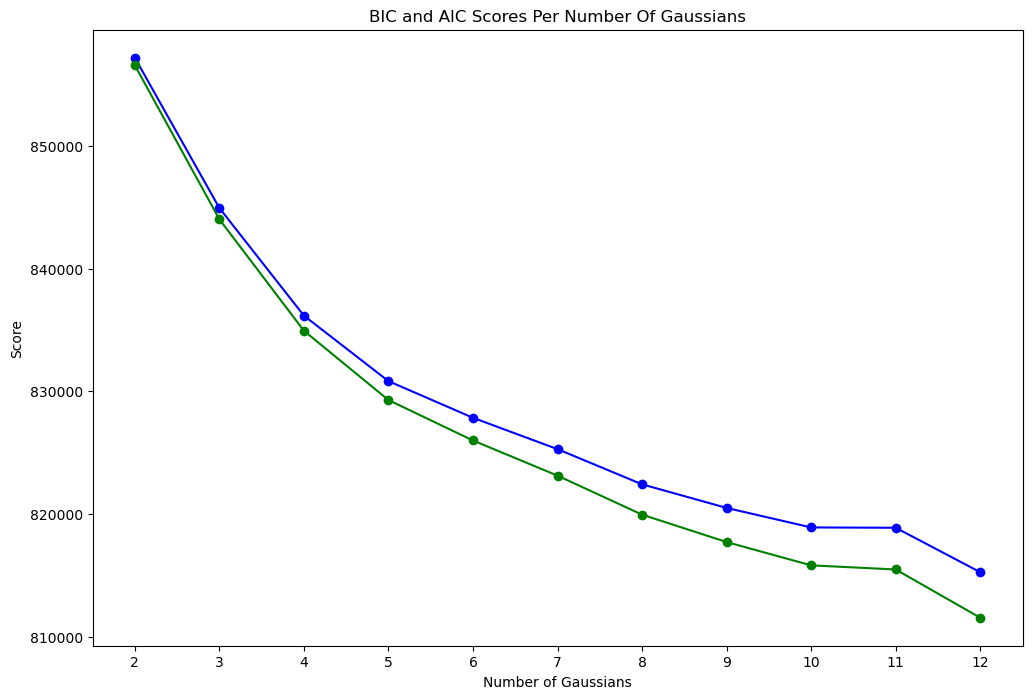

In [10]:
"""
Plotting the AIC vs BIC graph
"""
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(gaussian_range_size, bic_scores, '-o', color='blue')
ax.plot(gaussian_range_size, aic_scores, '-o', color='green')
ax.set(xlabel='Number of Gaussians', ylabel='Score')
ax.set_xticks(gaussian_range_size)
ax.set_title('BIC and AIC Scores Per Number Of Gaussians')

Text(0.5, 1.0, 'Siloutte Scores Per Number Of Gaussians')

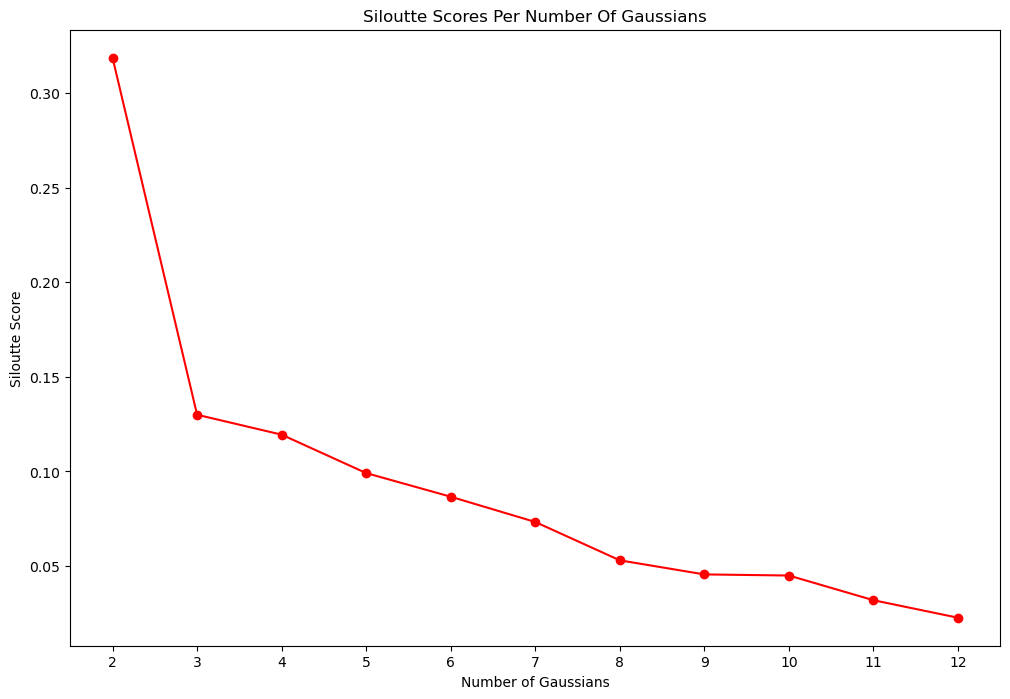

In [11]:
"""
Plotting the Siloutte Scores
"""
fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(gaussian_range_size, siloutte_scores, '-o', color='red')
ax.set(xlabel='Number of Gaussians', ylabel='Siloutte Score')
ax.set_xticks(gaussian_range_size)
ax.set_title('Siloutte Scores Per Number Of Gaussians')

In [12]:
"""
Apply Kmeans Clustering to the new transformed dataset
"""

# Range of Clusters we should try
k_range = range(2, 13)

# Hyperparameters for KMeans
init = "random"
n_init = 10
max_iter = 300
algorithm = "full"

# Lists to keep track the metric scores
inertia_scores = []
davies_bouldin_scores = []
siloutte_scores = []

for k in k_range:
    print(f"Trying size {k}...")
    km = KMeans(
        n_clusters = k,
        init = init,
        n_init = n_init,
        max_iter = max_iter,
        algorithm = algorithm,
        random_state = seed
    )
    
    km.fit(x_train_transformed)
    labels = km.labels_
    
    inertia_scores.append(km.inertia_)
    siloutte_scores.append(silhouette_score(x_train_transformed, labels, metric='euclidean'))
    davies_bouldin_scores.append(davies_bouldin_score(x_train_transformed, labels))
    


Trying size 2...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 3...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 4...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 5...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 6...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 7...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 8...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 9...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 10...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 11...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Trying size 12...


/Users/brandenkim/miniconda3/envs/ml_env/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1420: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Text(0.5, 1.0, 'Number of K and Effect on Inertia Scores')

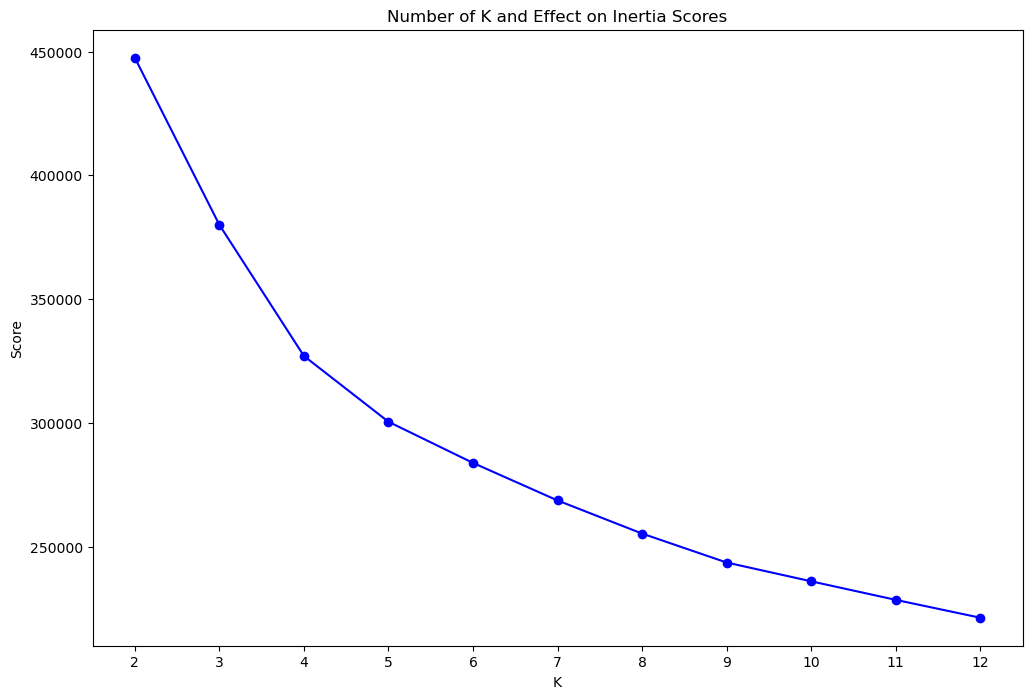

In [13]:
"""
Plotting the inertia scores from the clustering 
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(k_range, inertia_scores, '-o', color='blue')
ax.set(xlabel='K', ylabel='Score')
ax.set_xticks(k_range)
ax.set_title('Number of K and Effect on Inertia Scores')

Text(0.5, 1.0, 'Number of K and Effect on Silhouette Scores')

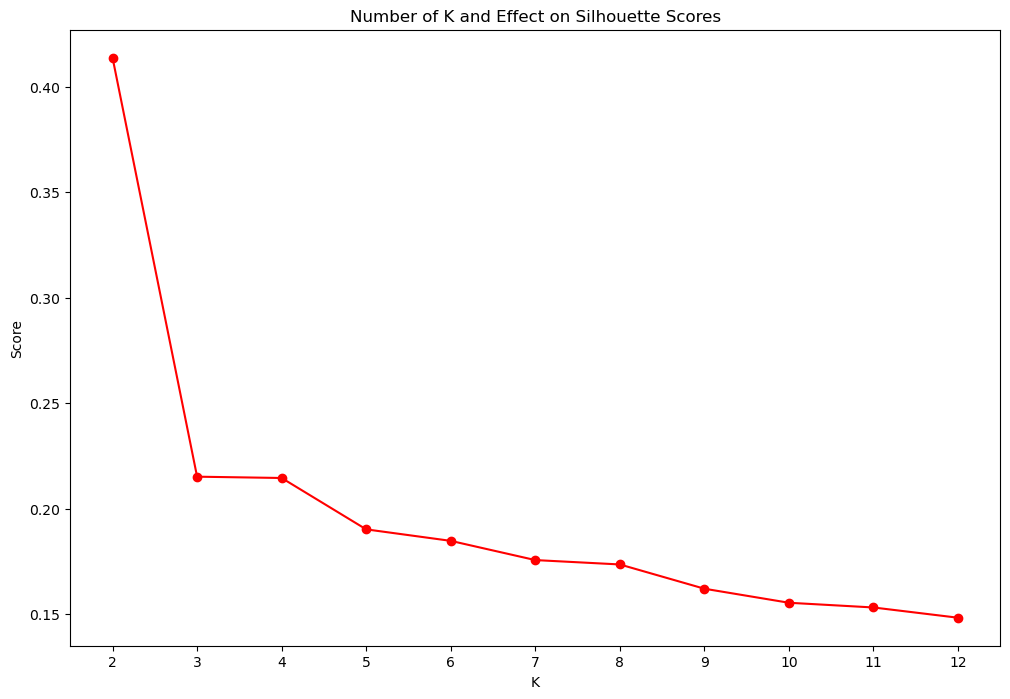

In [14]:
"""
Plotting the Siloutte Scores from the clustering
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(k_range, siloutte_scores, '-o', color='red')
ax.set(xlabel='K', ylabel='Score')
ax.set_xticks(k_range)
ax.set_title('Number of K and Effect on Silhouette Scores')

Text(0.5, 1.0, 'Number of K and Effect on Davies Bouldin Scores')

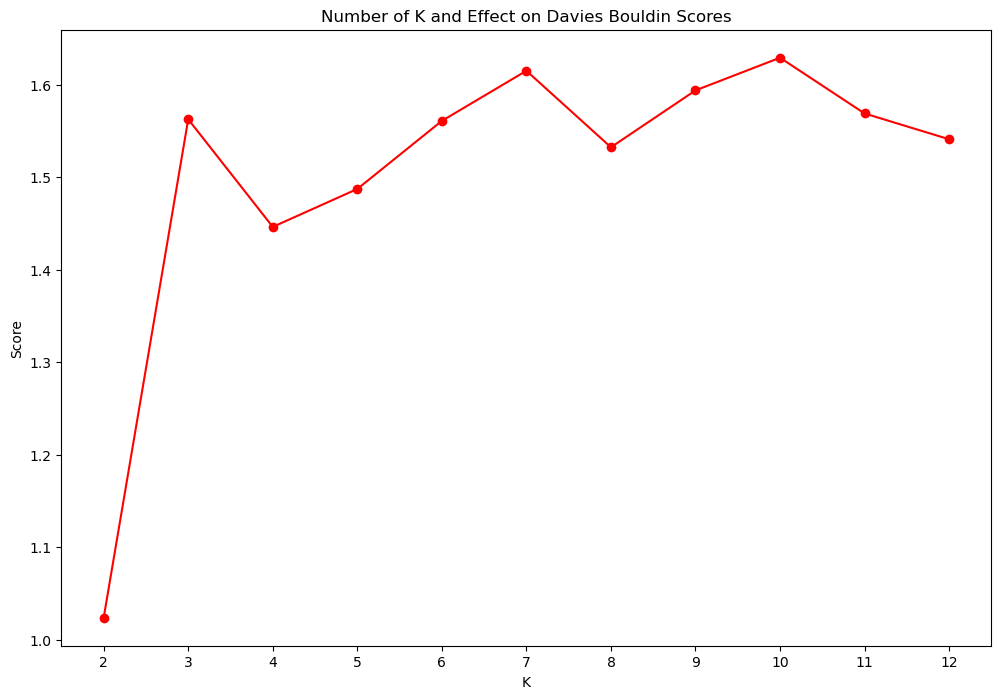

In [15]:
"""
Plotting the Davies Bouldin Scores from the clustering
"""

fig, ax = plt.subplots(figsize=(12,8),nrows=1)
ax.plot(k_range, davies_bouldin_scores, '-o', color='red')
ax.set(xlabel='K', ylabel='Score')
ax.set_xticks(k_range)
ax.set_title('Number of K and Effect on Davies Bouldin Scores')